# **Import Libraries**


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline

# **Prepare MNIST dataset to use**

In [ ]:
dataset_path = '/content/drive/MyDrive/Dissertation/project_code/dataset/'

In [ ]:
# Define a custom MNIST dataset
# Optionally return a spike raster instead of an image.

from torchvision import datasets, transforms


class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, is_spiking=False, time_window=100):
        super().__init__(
            root=root, train=train, download=True, transform=transforms.ToTensor()
        )
        self.is_spiking = is_spiking
        self.time_window = time_window

    def __getitem__(self, index):
        img, target = self.data[index].unsqueeze(0) / 255, self.targets[index]
        # img is now a tensor of 1x28x28

        if self.is_spiking:
            img = (torch.rand(self.time_window, *img.shape) < img).float()

        return img, target

In [ ]:
#Split into train and test datasets

from torch.utils.data import DataLoader

mnist_train = MNIST(dataset_path, train=True, is_spiking=False)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

mnist_test = MNIST(dataset_path, train=False, is_spiking=False)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

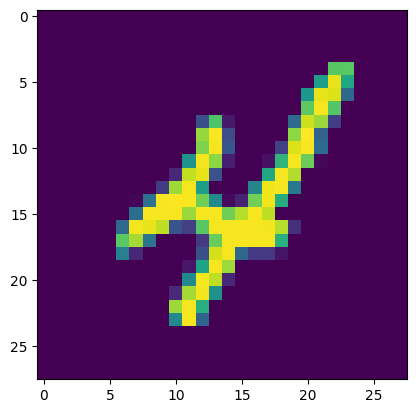

In [ ]:
# fig, axis = plt.subplots(2, 4, figsize=(8, 4))
# for i, ax in enumerate(axis.flat):
#   for i in range(2):
#     img, label = mnist_train[i]
#     ax.imshow(img.reshape(28,28,1), cmap='gray')

for i in range(10):
  img, label = mnist_train[i]
  plt.imshow(img.reshape(28,28))


# **Build and Train Sequential Pytorch CNN Model**


In [ ]:
#Sequential CNN Definition

import torch.nn as nn

ann = nn.Sequential(
    nn.Conv2d(1, 20, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),

    nn.Conv2d(20, 32, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),

    nn.Conv2d(32, 128, 3, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(128, 500, bias=False),
    nn.ReLU(),
    nn.Linear(500, 10, bias=False)

    )

In [ ]:
from torchsummary import summary
summary(ann, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             500
              ReLU-2           [-1, 20, 24, 24]               0
         AvgPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 32, 8, 8]          16,000
              ReLU-5             [-1, 32, 8, 8]               0
         AvgPool2d-6             [-1, 32, 4, 4]               0
            Conv2d-7            [-1, 128, 2, 2]          36,864
              ReLU-8            [-1, 128, 2, 2]               0
         AvgPool2d-9            [-1, 128, 1, 1]               0
          Flatten-10                  [-1, 128]               0
           Linear-11                  [-1, 500]          64,000
             ReLU-12                  [-1, 500]               0
           Linear-13                   [-1, 10]           5,000
Total params: 122,364
Trainable params:

In [ ]:
#train ann

from tqdm.auto import tqdm
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

#ann = ann().to(device)
ann.train()

optim = torch.optim.Adam(ann.parameters(), lr=1e-3)

n_epochs = 10

for n in tqdm(range(n_epochs)):
    for data, target in iter(train_loader):
        data, target = data.to(device), target.to(device)
        output = ann(data)
        optim.zero_grad()

        loss = F.cross_entropy(output, target)
        loss.backward()
        optim.step()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#Test ann for accuracy

correct_predictions = []

for data, target in iter(test_loader):
    data, target = data.to(device), target.to(device)
    output = ann(data)

    # get the index of the max log-probability
    pred = output.argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))

correct_predictions = torch.cat(correct_predictions)
print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)

Classification accuracy: 98.83%


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, ReLU, AvgPool2D, Flatten, Dense

# # Instantiate the Sequential model
# ann_keras = Sequential()

# # Add layers to the Sequential model
# ann_keras.add(Conv2D(20, kernel_size=(5, 5), strides=(1, 1), use_bias=False, input_shape=(height, width, channels)))
# ann_keras.add(ReLU())
# ann_keras.add(AvgPool2D(pool_size=(2, 2), strides=(2, 2)))

# ann_keras.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), use_bias=False))
# ann_keras.add(ReLU())
# ann_keras.add(AvgPool2D(pool_size=(2, 2), strides=(2, 2)))

# ann_keras.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), use_bias=False))
# ann_keras.add(ReLU())
# ann_keras.add(AvgPool2D(pool_size=(2, 2), strides=(2, 2)))

# ann_keras.add(Flatten())
# ann_keras.add(Dense(500, use_bias=False))
# ann_keras.add(ReLU())
# ann_keras.add(Dense(10, use_bias=False))

# # Display the model summary
# ann_keras.summary()


# **Sinab Framework**

In [ ]:
!pip install sinabs

In [ ]:
from sinabs.from_torch import from_model

input_shape = (1, 28, 28) #instantiate a SNN with the appropriate number of neurons because unlike traditional CNNs, SNNs are stateful
num_timesteps = 100  # per sample

sinabs_model = from_model(
    ann, input_shape=input_shape, add_spiking_output=True, synops=False, num_timesteps=num_timesteps
)

In [ ]:
sinabs_model.spiking_model

In [ ]:
test_batch_size = 100

spike_mnist_test = MNIST(
    dataset_path, train=False, is_spiking=True, time_window=num_timesteps
)
spike_test_loader = DataLoader(
    spike_mnist_test, batch_size=test_batch_size, shuffle=True
)

In [ ]:
import sinabs.layers as sl

correct_predictions = []

for data, target in tqdm(spike_test_loader):
    data, target = data.to(device), target.to(device)
    data = sl.FlattenTime()(data)
    with torch.no_grad():
        output = sinabs_model(data)
        output = output.unflatten(
            0, (test_batch_size, output.shape[0] // test_batch_size)
        )

    # get the index of the max log-probability
    pred = output.sum(1).argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))
    if len(correct_predictions) * test_batch_size >= 300:
        break

correct_predictions = torch.cat(correct_predictions)
print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)

#10 timesteps = 98.33% 1sec
#100 timesteps = 99.0% -- 11sec
#200 = 99.00% -- 26s
#300 = 99.67% -- 49s

  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 99.0%


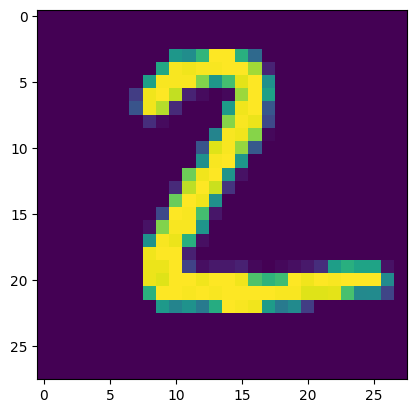

In [ ]:
img, label = spike_mnist_test[1]

plt.imshow(img.sum(0)[0]);

In [ ]:
snn_output = sinabs_model(img.to(device))

In [ ]:
import numpy as np

plt.pcolormesh(snn_output.T.detach().cpu())

plt.ylabel("Neuron ID")
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.xlabel("Time");

In [ ]:
# # configure bootstrap
# n_iterations = 1000
# datalength = 70000
# n_size = int(datalength * 0.20)
# # run bootstrap

# train = resample(spike_mnist_train, n_samples=n_size)

# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# # train the model
# loss_fn   = nn.BCELoss()  # binary cross entropy
# optimizer = optim.Adam(sinabs_model.parameters(), lr=0.001)

# n_epochs = 100
# batch_size = 10

# for epoch in range(n_epochs):
#     for i in range(0, len(X), batch_size):
#         Xbatch = X[i:i+batch_size]
#         y_pred = sinabs_model(Xbatch)
#         ybatch = y[i:i+batch_size]
#         loss = loss_fn(y_pred, ybatch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f'Finished epoch {epoch}, latest loss {loss}')

# # compute accuracy (no_grad is optional)
# with torch.no_grad():
#     y_pred = sinabs_model(X)

# accuracy = (y_pred.round() == y).float().mean()
# print(f"Accuracy {accuracy}")

# **Spiking Jelly Framework**

In [ ]:
!pip install spikingjelly

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import spikingjelly
from spikingjelly.activation_based import ann2snn
from tqdm import tqdm
#from spikingjelly.activation_based.ann2snn.sample_models import mnist_cnn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def val(net, device, data_loader, T=None):
    net.eval().to(device)
    correct = 0.0
    total = 0.0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch, (img, label) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            if T is None:
                out = net(img)
                correct += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            else:
                for m in net.modules():
                    if hasattr(m, 'reset'):
                        m.reset()
                for t in range(T):
                    if t == 0:
                        out = net(img)
                    else:
                        out += net(img)
                    corrects[t] += (out.argmax(dim=1) == label.to(device)).float().sum().item()
            total += out.shape[0]
    return correct / total if T is None else corrects / total

In [ ]:
T = 100


print('---------------------------------------------')
print('Converting using MaxNorm')
model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
snn_model = model_converter(ann)


print('Simulating...')
mode_max_accs = val(snn_model, device, test_loader, T=T)
print('SNN accuracy (simulation %d time-steps): %.4f' % (T, mode_max_accs[-1] * 100))

#MaxNorm
#10 = 96.35% 49sec
#100 = 99.28% 5mins
#200 = 99.26% 9mins
#300 = 99.24% 14mins


---------------------------------------------
Converting using MaxNorm


100%|██████████| 469/469 [00:35<00:00, 13.06it/s]


Simulating...


100%|██████████| 79/79 [05:31<00:00,  4.20s/it]

SNN accuracy (simulation 100 time-steps): 98.8200


In [ ]:
snn_model.eval

In [ ]:
#compute confidence level for spikingjelly

from sklearn.utils import resample
from matplotlib import pyplot
import numpy
# merge test and train datasets



# configure bootstrap
n_iterations = 1000
datalength = 70000
n_size = int(datalength * 0.20)
# run bootstrap
stats = list()
for i in range(n_iterations):
	# prepare train and test sets
	train = resample(mnist_train, n_samples=n_size)
	test = mnist_test #numpy.array([x for x in values if x.tolist() not in train.tolist()])
	# test model
	# model = DecisionTreeClassifier()
	# snn_model.fit(train[:,:-1], train[:,-1])
	# evaluate model
	# predictions = snn_model.predict(test[:,:-1])
	score = val(snn_model, device, test_loader, T=T)
	print(score)
	stats.append(score)
# plot scores
pyplot.hist(stats)
pyplot.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, numpy.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, numpy.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

100%|██████████| 79/79 [04:46<00:00,  3.63s/it]


[0.098  0.098  0.098  0.098  0.1005 0.2315 0.6251 0.8487 0.9317 0.9609
 0.972  0.9789 0.9815 0.9821 0.9845 0.9852 0.9854 0.9859 0.9864 0.9863
 0.9871 0.9869 0.9871 0.987  0.9871 0.9872 0.9876 0.9878 0.9872 0.9875
 0.9875 0.9875 0.9875 0.9878 0.988  0.9879 0.9879 0.988  0.9881 0.9883
 0.9881 0.9882 0.988  0.9879 0.9883 0.9884 0.9885 0.9882 0.9885 0.9883
 0.9887 0.9884 0.9884 0.9886 0.9884 0.9884 0.9886 0.9886 0.9885 0.9885
 0.9887 0.9885 0.9884 0.9884 0.9884 0.9884 0.9886 0.9885 0.9885 0.9884
 0.9883 0.9884 0.9883 0.9885 0.9885 0.9884 0.9883 0.9883 0.9884 0.9881
 0.9883 0.9883 0.9883 0.9882 0.9883 0.9883 0.9882 0.9883 0.9883 0.9883
 0.9883 0.9883 0.9884 0.9881 0.9883 0.9881 0.988  0.9881 0.9881 0.9882]


100%|██████████| 79/79 [04:42<00:00,  3.58s/it]


[0.098  0.098  0.098  0.098  0.1005 0.2315 0.6251 0.8487 0.9317 0.9609
 0.972  0.9789 0.9815 0.9821 0.9845 0.9852 0.9854 0.9859 0.9864 0.9863
 0.9871 0.9869 0.9871 0.987  0.9871 0.9872 0.9876 0.9878 0.9872 0.9875
 0.9875 0.9875 0.9875 0.9878 0.988  0.9879 0.9879 0.988  0.9881 0.9883
 0.9881 0.9882 0.988  0.9879 0.9883 0.9884 0.9885 0.9882 0.9885 0.9883
 0.9887 0.9884 0.9884 0.9886 0.9884 0.9884 0.9886 0.9886 0.9885 0.9885
 0.9887 0.9885 0.9884 0.9884 0.9884 0.9884 0.9886 0.9885 0.9885 0.9884
 0.9883 0.9884 0.9883 0.9885 0.9885 0.9884 0.9883 0.9883 0.9884 0.9881
 0.9883 0.9883 0.9883 0.9882 0.9883 0.9883 0.9882 0.9883 0.9883 0.9883
 0.9883 0.9883 0.9884 0.9881 0.9883 0.9881 0.988  0.9881 0.9881 0.9882]


100%|██████████| 79/79 [04:59<00:00,  3.79s/it]


[0.098  0.098  0.098  0.098  0.1005 0.2315 0.6251 0.8487 0.9317 0.9609
 0.972  0.9789 0.9815 0.9821 0.9845 0.9852 0.9854 0.9859 0.9864 0.9863
 0.9871 0.9869 0.9871 0.987  0.9871 0.9872 0.9876 0.9878 0.9872 0.9875
 0.9875 0.9875 0.9875 0.9878 0.988  0.9879 0.9879 0.988  0.9881 0.9883
 0.9881 0.9882 0.988  0.9879 0.9883 0.9884 0.9885 0.9882 0.9885 0.9883
 0.9887 0.9884 0.9884 0.9886 0.9884 0.9884 0.9886 0.9886 0.9885 0.9885
 0.9887 0.9885 0.9884 0.9884 0.9884 0.9884 0.9886 0.9885 0.9885 0.9884
 0.9883 0.9884 0.9883 0.9885 0.9885 0.9884 0.9883 0.9883 0.9884 0.9881
 0.9883 0.9883 0.9883 0.9882 0.9883 0.9883 0.9882 0.9883 0.9883 0.9883
 0.9883 0.9883 0.9884 0.9881 0.9883 0.9881 0.988  0.9881 0.9881 0.9882]


 57%|█████▋    | 45/79 [03:07<02:22,  4.18s/it]


KeyboardInterrupt: 

# **Binds NET**


In [ ]:
# !pip install bindsnet


In [ ]:
# data = dataset_path
# args_percentile = 99.7
# args_batch_size = 100
# args_seed = 0
# args_time = 80
# n_workers = 4
# args_eval_size = -1

  # parser = argparse.ArgumentParser()
  #   parser.add_argument("--job-dir", type=str, required=True, help='The working directory to store results')
  #   parser.add_argument("--model", type=str, required=True, help='The path to the pretrained model')
  #   parser.add_argument("--results-file", type=str, default='sim_result.txt', help='The file to store simulation result')
  #   parser.add_argument("--seed", type=int, default=0, help='A random seed')
  #   parser.add_argument("--time", type=int, default=80, help='Time steps to be simulated by the converted SNN (default: 80)')
  #   parser.add_argument("--batch-size", type=int, default=100, help='Mini batch size')
  #   parser.add_argument("--
  #   n-workers ", type=int, default=4, help='Number of data loaders')
  #   parser.add_argument("--norm", type=int, default=128, help='The amount of data to be normalized at once')
  #   parser.add_argument("--gpu", action="store_true", help='Whether to use GPU or not')
  #   parser.add_argument("--one-step", action="store_true", help='Single step inference flag')
  #   parser.add_argument('--data', metavar='DATA_PATH', default='./data/',
  #                       help='The path to ImageNet data (default: \'./data/)\', CIFAR-100 will be downloaded')
  #   parser.add_argument("--arch", type=str, default='vgg15ab', help='ANN architecture to be instantiated')
  #   parser.add_argument("--percentile", type=float, default=99.7, help='The percentile of activation in the training set to be used for normalization of SNN voltage threshold')
  #   parser.add_argument("--eval_size", type=int, default=-1, help='The amount of samples to be evaluated (default: evaluate all)')
  #   parser.add_argument("--dataset", type=str, default='cifar100', help='cifar100 or imagenet')

In [ ]:
# from bindsnet.conversion import ann_to_snn
# from bindsnet.encoding import RepeatEncoder
# from time import time
# data = torch.rand(784, 20)

# input_shape = (28, 28, 1)
# snn = ann_to_snn(ann, input_shape=input_shape, data=data, percentile=args_percentile)


# torch.cuda.empty_cache()
# snn = snn.to(device)

# correct = 0

# accuracies = np.zeros((args_time, (args_eval_size//args_batch_size)+1), dtype=np.float32)

# for step, batch in enumerate(tqdm(train_loader)):
#     if (step+1)*args_batch_size > args_eval_size:
#         break
#     # Prep next input batch.
#     inputs = batch["encoded_image"]
#     labels = batch["label"]
#     inpts = {"Input": inputs}
#     # if args.gpu:
#     #     inpts = {k: v.cuda() for k, v in inpts.items()}

#     snn.run(inpts=inpts, time=args_time, step=step, acc= accuracies, labels=labels,one_step=args.one_step)
#     last_layer = list(snn.layers.keys())[-1]
#     output_voltages = snn.layers[last_layer].summed
#     prediction = torch.softmax(output_voltages, dim=1).argmax(dim=1)
#     correct += (prediction.cpu() == labels).sum().item()
#     snn.reset_()

# # t1 = time() - t0

# final = accuracies.sum(axis=1) / args_eval_size

# plt.plot(final)
# # plt.suptitle('{} {} ANN-SNN@{} percentile'.format(args.dataset, args.arch, args.percentile), fontsize=20)
# plt.xlabel('Timestep', fontsize=19)
# plt.ylabel('Accuracy', fontsize=19)
# plt.grid()
# plt.show()
# # plt.savefig('{}/{}_{}.png'.format(args.job_dir, args.arch, args.percentile))
# #np.save('{}/voltage_accuracy_{}_{}.npy'.format(args.job_dir, args.arch, args.percentile), final)


# accuracy = 100 * correct / args_eval_size

# print(f"SNN accuracy: {accuracy:.2f}")
# # print(f"Clock time used: {t1:.4f} ms.")
# # path = os.path.join(args.job_dir, "results", args.results_file)
# # os.makedirs(os.path.dirname(path), exist_ok=True)
# # if not os.path.isfile(path):
# #     with open(path, "w") as f:
# #         f.write("seed,simulation time,batch size,inference time,accuracy\n")
# # to_write = [args.seed, args.time, args.batch_size, t1, accuracy]
# # to_write = ",".join(map(str, to_write)) + "\n"
# # with open(path, "a") as f:
# #     f.write(to_write)

# # return t1


